In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

seed = 256
torch.manual_seed(seed)
np.random.seed(seed)

## Plotting Utilities

In [3]:
from matplotlib.patches import Rectangle

def plot_hypercubes(
    ax, hypercubes: torch.Tensor, base_prediction: torch.Tensor, colors, alpha=0.4
):

    for h, bp in zip(hypercubes, base_prediction):
        low, high = h[:, 0], h[:, 1]
        side_lengths = high - low

        patch = Rectangle(
            low, side_lengths[0], side_lengths[1], facecolor=colors[bp], alpha=alpha
        )
        ax.add_patch(patch)

## Data Generation

In [4]:
from sklearn.datasets import make_circles
from torch_mas.data import DataBuffer

X, y = make_circles(n_samples = 1000, noise=0.1, factor=0.7, random_state=seed)
y[y == 0] = -1
dataset = DataBuffer(torch.as_tensor(X,dtype=torch.float), torch.as_tensor(y,dtype=torch.float).unsqueeze(-1))

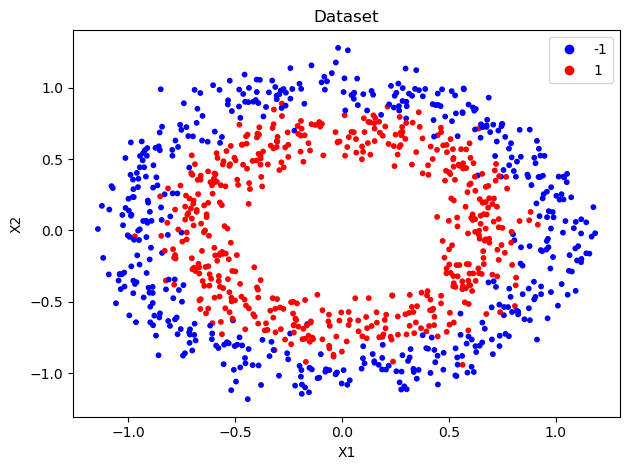

In [5]:
fig = plt.gcf()
ax = plt.gca()

scatter = ax.scatter(X[:,0],X[:,1],s=10,c=y,cmap='bwr')

ax.set_xlabel("X1")
ax.set_ylabel("X2")

ax.set_title('Dataset')
ax.legend(handles=scatter.legend_elements()[0],labels=['-1','1'])
plt.tight_layout()
plt.show()

## Model Training

In [14]:
import time
from torch_mas.batch.trainer import ClassifTrainer as Trainer
from torch_mas.batch.internal_model import SVM
from torch_mas.batch.activation_function import BaseActivation


validity = BaseActivation(
    dataset.input_dim, 
    dataset.output_dim, 
    alpha=0.1, 
)
internal_model = SVM(
    dataset.input_dim, 
    dataset.output_dim, 
    memory_length=10, 
)
model = Trainer(
    validity,
    internal_model,
    R=0.3,
    imprecise_th=0.0015,
    bad_th=0.1,
    n_epochs=20,
    batch_size=32
)

t = time.time()
model.fit(dataset)
tt = time.time() - t
print(f"Total training time: {tt}s")

print("Number of agents created:", model.n_agents)

Total training time: 5.015307903289795s
Number of agents created: 165


### Agents Visualization

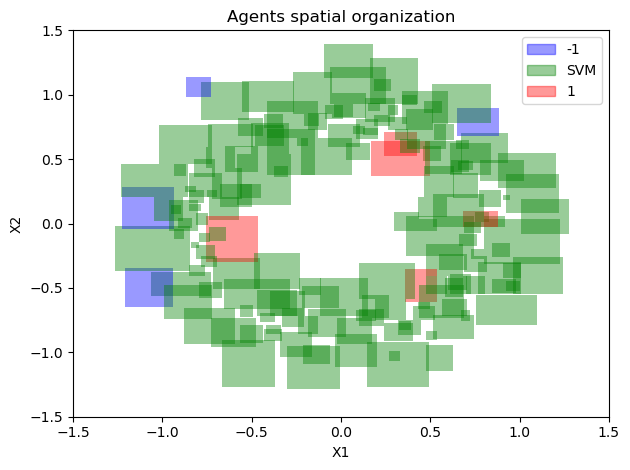

In [15]:
fig = plt.gcf()
ax = plt.gca()

plot_hypercubes(ax,model.activation.orthotopes.detach().numpy(),model.internal_model.base_prediction.numpy(),colors = {-1: "b", 0: "g", 1: "r"})

ax.set_xlabel("X1")
ax.set_ylabel("X2")

custom_handles = [
    plt.Rectangle((0, 0), 1, 1, color='b', alpha=0.4),
    plt.Rectangle((0, 0), 1, 1, color='g', alpha=0.4),
    plt.Rectangle((0, 0), 1, 1, color='r', alpha=0.4),
]
custom_labels = ["-1", "SVM", "1"]

ax.legend(handles=custom_handles, labels=custom_labels)

ax.set_xlim(-1.5,1.5)
ax.set_ylim(-1.5,1.5)
ax.set_title('Agents spatial organization')
plt.tight_layout()
plt.show()